# Home Assignment No. 2: Part 1 (Practice)
To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

To begin with, let's import the essential (for this assignment) libraries.

## Task 1.1. Boosting, part 1. (2 points)

Boosting Machines (BM) are a family of widely popular and effective methods for classification and regression tasks. The main idea behind BMs is that **combining weak learners**, that perform slightly better than random, can result in **strong learning models**.

In the following exercise you will be asked to partially implement one of the earlier variants of BMs - **AdaBoost** and compare it to the already existing `sklearn` implementation. AdaBoost utilizes the greedy training approach: firstly we train the weak learners (they are later called `base_classifiers`) on the whole dataset and in the next iterations we train the model on the samples, on the which the previous models have performed poorly. This behavior is acheived by reweighting the training samples during each algorithm's step. 

The pseudocode for AdaBoost can be found in [Lecture 7](https://github.com/adasegroup/ML2020_lectures).

**(The task)**:
* Complete the `ada_boost_alpha` and `ada_boost_distribution` functions
* Complete the `.fit` method of `Boosting` class
* Complete the `.predict` method of `Boosting` class


**The resulting implementation should achieve similar accuracy to the implementataion from `sklearn` and the decision bounds plots should also be almost identical. In addtion, make sure that the following formula is true:**

$$|\text{your_accuracy} - \text{sklearn_accuracy}| \leq 0.005$$

In [1]:
### Import libraries, create dataset and split it to training and test sets

%matplotlib inline
#from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# base classifier
from sklearn.tree import DecisionTreeClassifier

np.random.seed(1)
import warnings
warnings.filterwarnings('ignore')

In [2]:
### Plot the dataset

X, y = make_moons(n_samples=1000, noise=0.3, random_state=0)

# for convenience convert labels from {0, 1} to {-1, 1}
y[y == 0] = -1

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 30),
                     np.linspace(y_min, y_max, 30))

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

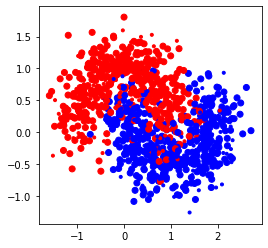

In [4]:
# Plot the training points
plt.figure(figsize=(4, 4))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
plt.scatter(X_test[:, 0], X_test[:, 1], marker='.', c=y_test, cmap=cm_bright)

* `ada_boost_alpha` - function, which calculates the weights of the linear combination of the classifiers
* `ada_boost_distribution` - function, which calculates sample weights

In [5]:
### Now let us define functions to calculate alphas and distributions for AdaBosot algorithm

def ada_boost_alpha(y, y_pred_t, distribution):
    """
    y_pred_t is a prediction of the t-th base classifier
    """
    # ====== Your code here =====
    
    res = y*y_pred_t
    res[res>0] = 0
    res[res<0] = 1
    N = distribution@res.reshape(-1,1)
    alpha = .5 * np.log((1-N)/N)
    return alpha
    

def ada_boost_distribution(y, y_pred_t, distribution, alpha_t):
    """
    y_pred_t is a prediction of the t-th base classifier
    """

    # ====== Your code here =====
    distribution = distribution*np.exp(-alpha_t*np.multiply(y,y_pred_t))
    
    return distribution

In [6]:
class Boosting():
    """
    Generic class for construction of boosting models
    
    :param n_estimators: int, number of estimators (number of boosting rounds)
    :param base_classifier: callable, a function that creates a weak estimator. Weak estimator should support sample_weight argument
    :param get_alpha: callable, a function, that calculates new alpha given current distribution, prediction of the t-th base estimator,
                      boosting prediction at step (t-1) and actual labels
    :param get_distribution: callable, a function, that calculates samples weights given current distribution, prediction, alphas and actual labels
    """
    def __init__(self, n_estimators=50, base_classifier=None,
                 get_alpha=ada_boost_alpha, update_distribution=ada_boost_distribution):
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.get_alpha = get_alpha
        self.update_distribution = update_distribution
        
    def fit(self, X, y):
        n_samples = len(X)
        distribution = np.ones(n_samples, dtype=float) / n_samples
        self.classifiers = []
        self.alphas = []
        self.scores = []
        for i in range(self.n_estimators):
            # create a new classifier
            self.classifiers.append(self.base_classifier())     
            self.classifiers[-1].fit(X, y, sample_weight=distribution)

            # ======= Your code here ======
            
            # make a prediction
            y_pred = self.classifiers[-1].predict(X)
            
            #update alphas, append new alpha to self.alphas
            self.alphas.append(self.get_alpha(y, y_pred, distribution))
            
            # update distribution and normalize
            distribution = self.update_distribution(y, y_pred, distribution, self.alphas[-1])
            distribution = distribution/sum(distribution)
    
    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
    
        # ====== Your code here ======
        #get the weighted votes of the classifiers
        pred = 0
        for cl,al in zip( self.classifiers, self.alphas):
          pred += al*cl.predict(X)
        out = np.sign(pred)
        return out

In [7]:
from sklearn.ensemble import AdaBoostClassifier

max_depth = 5
n_estimators = 100

get_base_clf = lambda: DecisionTreeClassifier(max_depth=max_depth)

ada_boost1 = Boosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf)
ada_boost1.fit(X_train, y_train)

ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [8]:
classifiers = [ada_boost1, ada_boost_sklearn]
names = ['ada_boost', 'ada_boost_sklearn']

accuracy ada_boost: 0.895
accuracy ada_boost_sklearn: 0.895
delta: 0.0


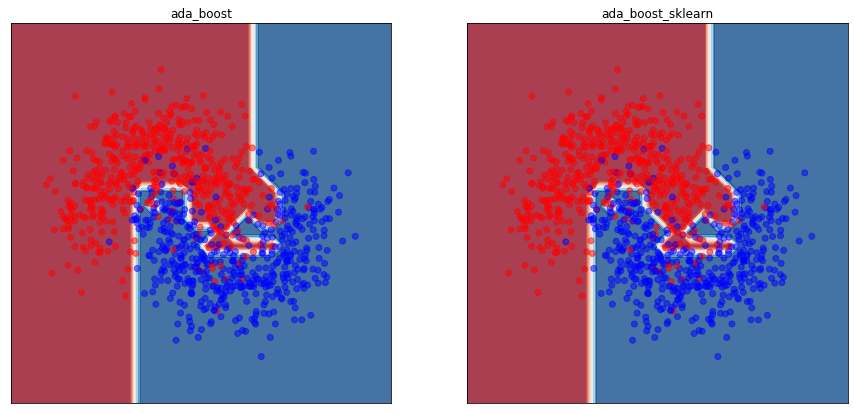

In [9]:
# # test ensemble classifier
plt.figure(figsize=(15, 7))
predictionss = []
for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)

    # Put the result into a color plot
    ax = plt.subplot(1, len(classifiers), i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(names[i])

    print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test)))
    predictionss.append((prediction == y_test).sum() * 1. / len(y_test))
    
print("delta: {}".format(predictionss[1] - predictionss[0]))
    

## Task 1.2. Boosting, part 2. (2 points)

For adaboost we have computed each alpha according to the formula:

$$\alpha_t = \frac{1}{2}\log{\frac{1-N_T(h_T, w_T )}{N_T(h_T,w_t)}}$$

In the next task you will be asked to instead recompute all of the alphas after adding another estimator to the composition of models, i.e. when the new classifier is fitted to the weighted data samples, the new alphas should be recomputed by directly minimizing the exponential loss, for all the avaliable estimators. Take into account, that at each step of the boosting algorithm **all** alphas and, consequntly, **all** sample weights should be recomputed from scratch. 

**The task**:
* Complete the `recompute_alpha` and `recompute_distribution` functions
* Complete the `.fit` method of `RecomputeBoosting` class
* Complete the `.predict` method of `RecomputeBoosting` class
* Plot the resulting alphas (last calculated in case of recomputed alphas) and plot the scores of the resulting model at each iteration (use ```predict```, ```score``` and ```construct_alpha_history``` functions defined below) for both RecomputedBoosting and AdaBoost (it can be either your own implementation from Exercise 1.1 or the one from sklearn - in this case use ```.estimator_weights_```, ```.estimators_```)
* Make a conclusion about which method is better and in which case - in order to do that, if it is not clear from the resulting plots, you can addtitionally vary the parameters of the training (number and depth of the estimators, noise of the data (moons))  



**HINTS:**

In order to minimize the exponential loss with respect to alpha, use the [```scipy.optimize.minimize```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function.

When defining the function to minimize (in case of AdaBoost it should be the exponential loss), have a look at the optimization problem formulation of Ridge Regression and at the reguralization parameter([Lecture 2, slide 14](https://github.com/adasegroup/ML2020_lectures/blob/master/lecture2/Lecture_2_Regression.pdf)). Add it in order to guarantee the existence of the solution.

In [10]:
from scipy.optimize import minimize

In [11]:
def recompute_alpha(y, y_pred, C):
    """
    y_pred - is a list of predictions of the existing estimators
    C - is a reguralization term    
    """
    # ====== Your code here =====
    y_pred = np.array(y_pred)
    alpha_zeros = np.random.uniform(1,size=(y_pred.shape[0])).reshape(-1,1)
    func = lambda alpha: np.mean(np.exp(-y*np.dot(alpha,y_pred))) + C* np.linalg.norm(alpha)**2
    alphas = minimize(func,alpha_zeros,method='CG')
    return alphas["x"]

def recompute_distribution(y, y_pred, alphas):
    """
    y_pred - is a list of predictions of the existing estimators
    alphas - are the last recomputed alphas
    """

    # ====== Your code here =====
    y_pred = np.array(y_pred)
    alphas = np.array(alphas).reshape(-1,1)
    distribution = np.exp(-y*np.dot(alphas.T,y_pred))

    return distribution.reshape(-1)

In [12]:
class RecomputedBoosting():
    """
    Generic class for construction of boosting models
    
    :param n_estimators: int, number of estimators (number of boosting rounds)
    :param base_classifier: callable, a function that creates a weak estimator. Weak estimator should support sample_weight argument
    :param get_alpha: callable, a function, that calculates new alpha given current distribution, prediction of the t-th base estimator,
                      boosting prediction at step (t-1) and actual labels
    :param get_distribution: callable, a function, that calculates samples weights given current distribution, prediction, alphas and actual labels
    """
    def __init__(self, n_estimators=50, base_classifier=None,
                 get_alpha=recompute_alpha, update_distribution=recompute_distribution, C=1.0):
        self.n_estimators = n_estimators
        self.base_classifier = base_classifier
        self.get_alpha = get_alpha
        self.update_distribution = update_distribution
        self.C = C
        
    def fit(self, X, y):
        n_samples = len(X)
        distribution = np.ones(n_samples, dtype=float) / n_samples
        self.classifiers = []
        
        #notice how alpha is a matrix - we will store the history of the updates here
        self.alphas = np.zeros((n_estimators, n_estimators))
        for i in range(self.n_estimators):
            # create a new classifier
            self.classifiers.append(self.base_classifier())        
            self.classifiers[-1].fit(X, y, sample_weight=distribution)
            
            # ======= Your code here ======
            # create a list of predictions across all classifiers
            preds = []
            for clf in self.classifiers:
              preds.append(clf.predict(X))
        
            # recalculate alphas, add them to the matrix of self.alphas 
            # NOTE: here, self.alphas is a history of computed alphas at each step i
            
            alphas = self.get_alpha(y, preds, self.C)
            self.alphas[0:len(alphas),i] = alphas
            
            # update distribution and normalize
            distribution = np.ones(n_samples, dtype=float) / n_samples
            dist = distribution*self.update_distribution(y, preds, alphas)
            distribution = dist/sum(dist)
    
    def predict(self, X):
        final_predictions = np.zeros(X.shape[0])
        # ====== Your code here ======
        #get the weighted votes of the classifiers
        #do not forget that self.alphas is the whole history of recalculated alphas!
        pred = 0
        for i,clf in enumerate(self.classifiers):
          pred += self.alphas[i,-1]*clf.predict(X)
        out = np.sign(pred)
        return out

In [13]:
from sklearn.ensemble import AdaBoostClassifier

ada_boost = RecomputedBoosting(n_estimators=n_estimators,
                     base_classifier=get_base_clf, get_alpha=recompute_alpha, 
                     update_distribution=recompute_distribution, C=1.0)
ada_boost.fit(X_train, y_train)

ada_boost_sklearn = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth),
                                       algorithm="SAMME",
                                       n_estimators=n_estimators)

ada_boost_sklearn.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=5,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

100


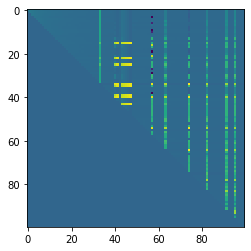

In [14]:
plt.imshow(ada_boost.alphas)
print(len(ada_boost.classifiers))

In [15]:
classifiers = [ada_boost, ada_boost_sklearn]
names = ['ada_boost', 'ada_boost_sklearn']

accuracy ada_boost: 0.9
accuracy ada_boost_sklearn: 0.895


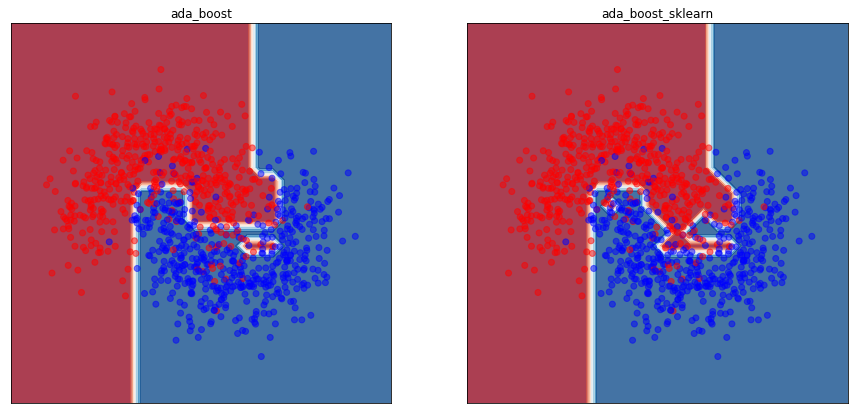

In [16]:
# # test ensemble classifier
plt.figure(figsize=(15, 7))
for i, clf in enumerate(classifiers):
    prediction = clf.predict(X_test)

    # Put the result into a color plot
    ax = plt.subplot(1, len(classifiers), i + 1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, alpha=0.5)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(names[i])

    print('accuracy {}: {}'.format(names[i], (prediction == y_test).sum() * 1. / len(y_test)))

In [17]:
from sklearn.metrics import accuracy_score

def score(alphas, estimators, X, y):
#     print( predict(alphas, estimators, X))
#     print("alphas shape: ", alphas.shape)
#     print("estimators shape: ", len(estimators))
    return accuracy_score(y, predict(alphas, estimators, X))

def predict(alphas, estimators, X, y=None):
    return np.sign(sum(
        b * e.predict(X) for b, e in zip(alphas, estimators)
    ))

def construct_alpha_history(init_alphas):
    """
    construct alpha history, alike recomputed alpha history, for AdaBoost algorithm
    """
    alphas = np.zeros((len(init_alphas), len(init_alphas)))
    for t, alpha in enumerate(init_alphas):
        alphas[t:, t] = alpha
    return alphas

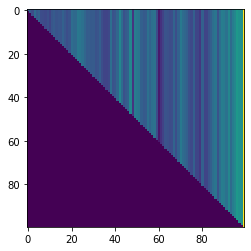

In [18]:
construct_alpha_history(ada_boost1.alphas)[:5,:5]
plt.imshow(np.flip(construct_alpha_history(ada_boost1.alphas)))
# print(len(ada_boost.classifiers))
# len(ada_boost1.alphas)

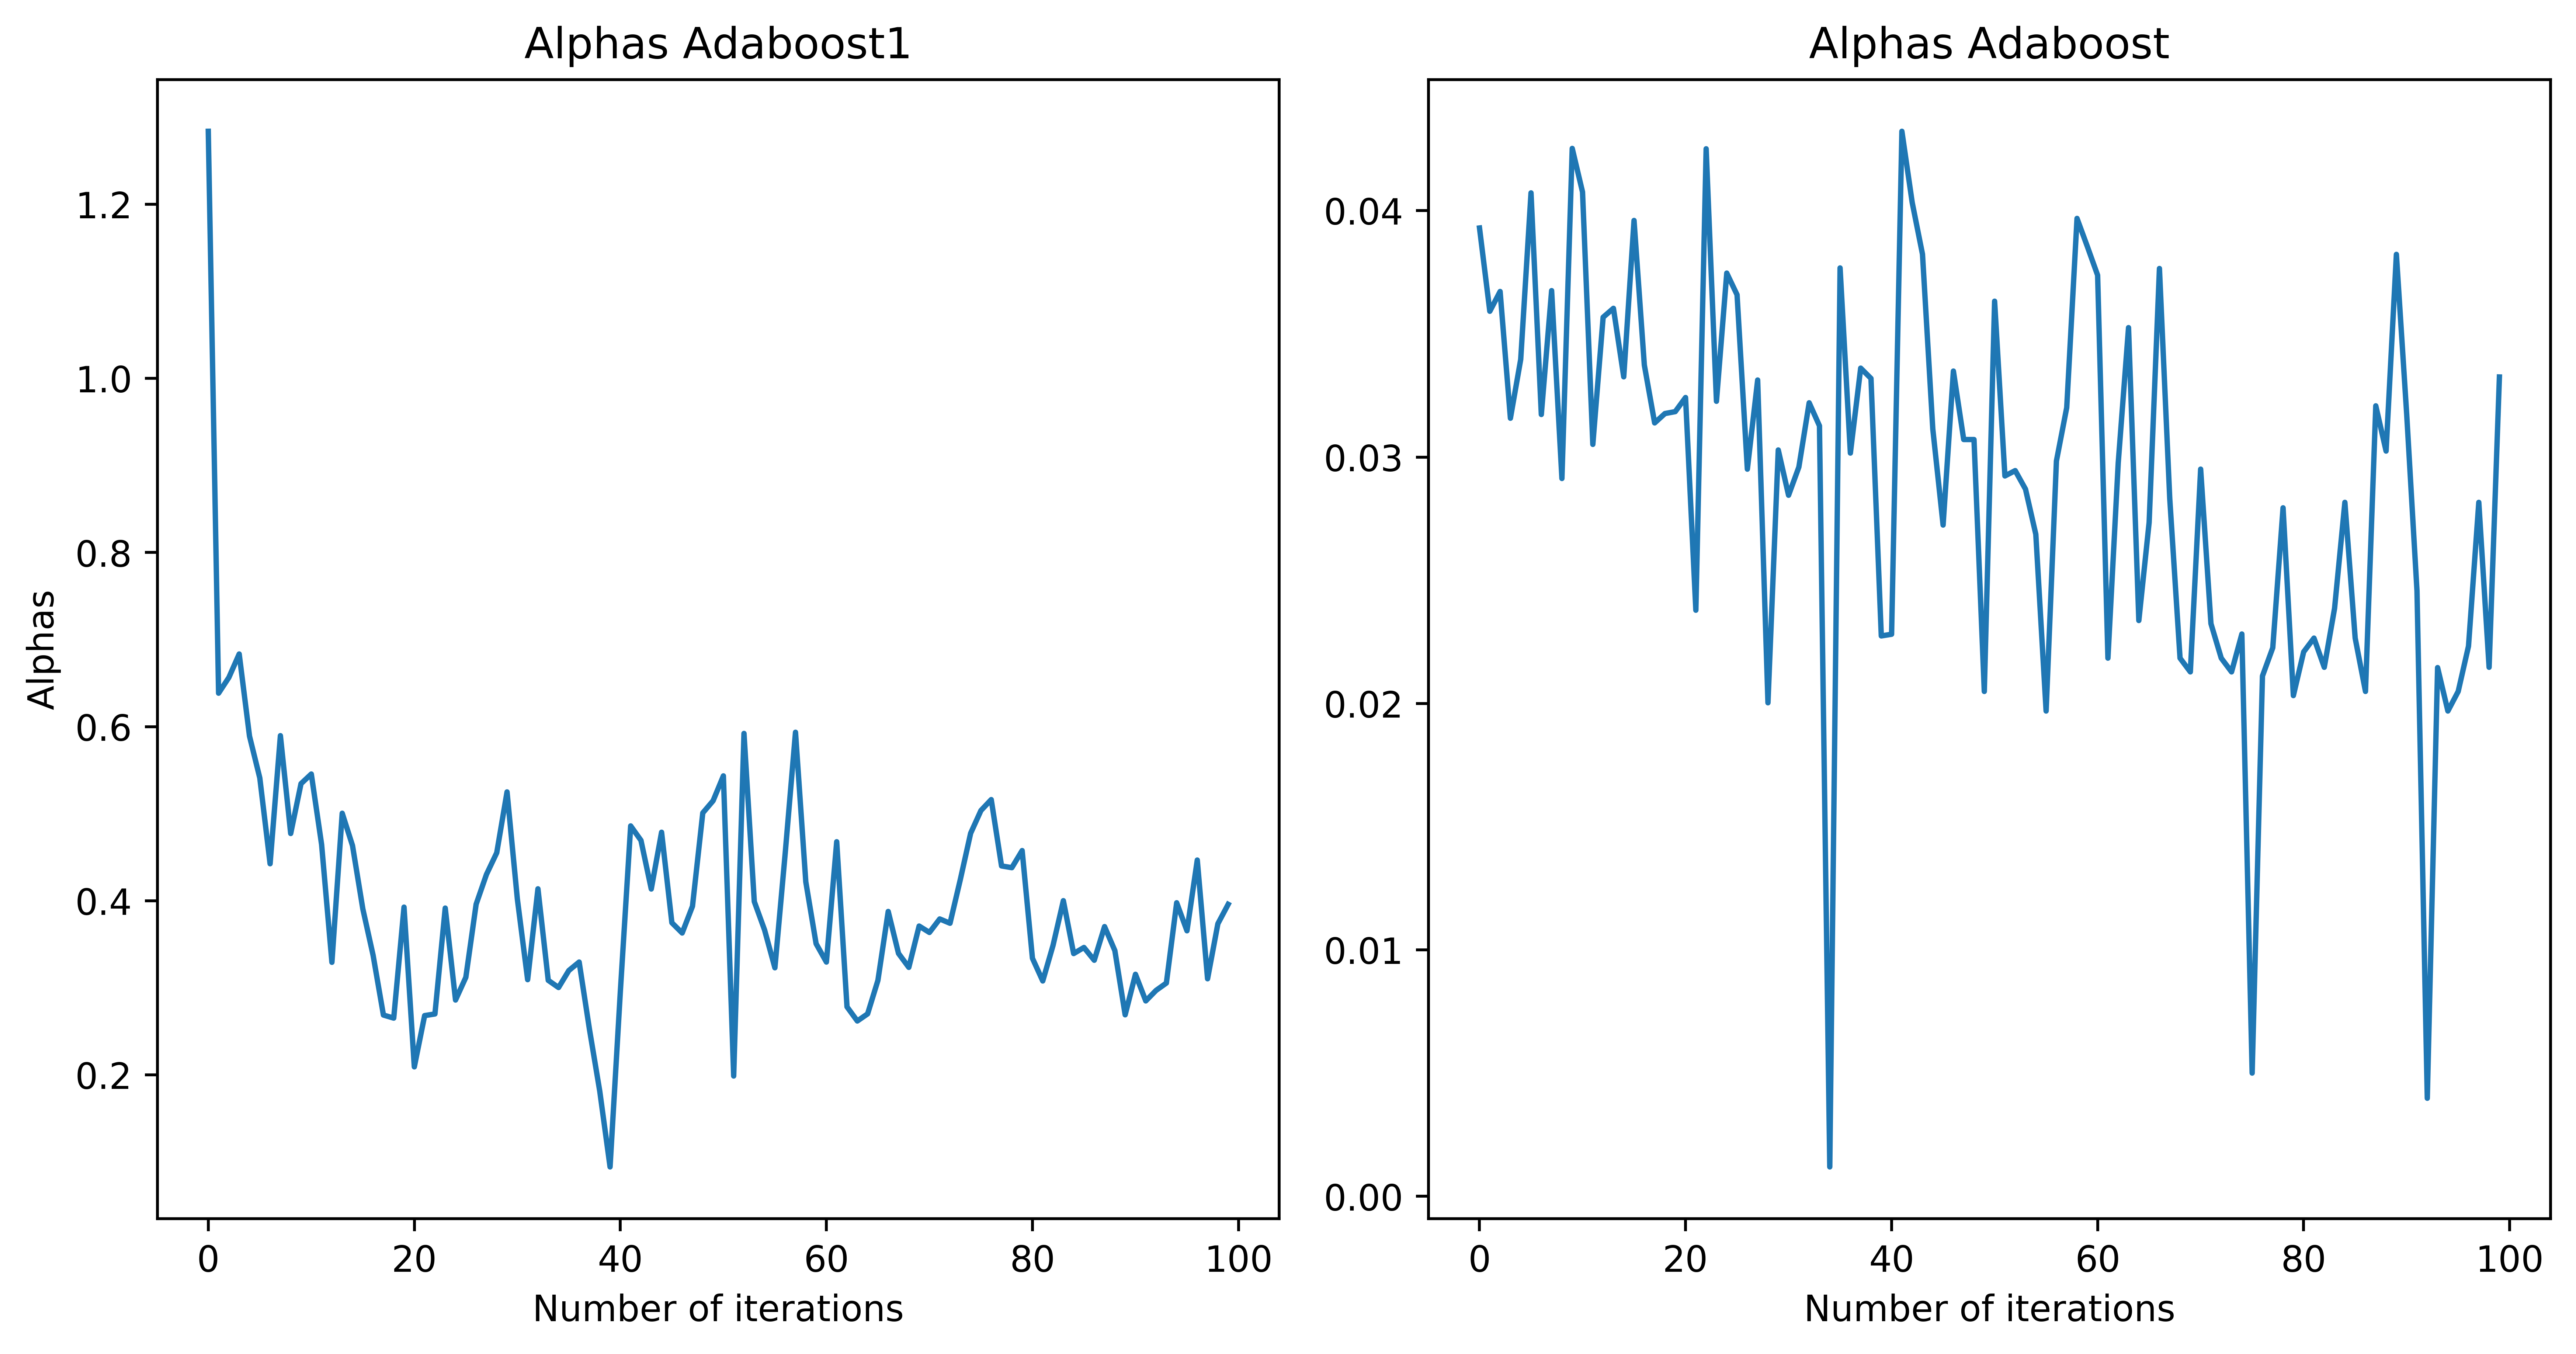

In [19]:
## Plot the resulting alphas (last calculated in case of recomputed alphas)
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,figsize=(10,5), dpi=700)
plt.tight_layout()
ax1.plot(range(len(ada_boost1.alphas)),ada_boost1.alphas)
ax1.set_title('Alphas Adaboost1')
ax1.set_xlabel('Number of iterations')
ax2.plot(range(ada_boost.alphas.shape[0]),ada_boost.alphas[:,-1])
ax2.set_title('Alphas Adaboost');
ax2.set_xlabel('Number of iterations')
ax1.set_ylabel('Alphas');

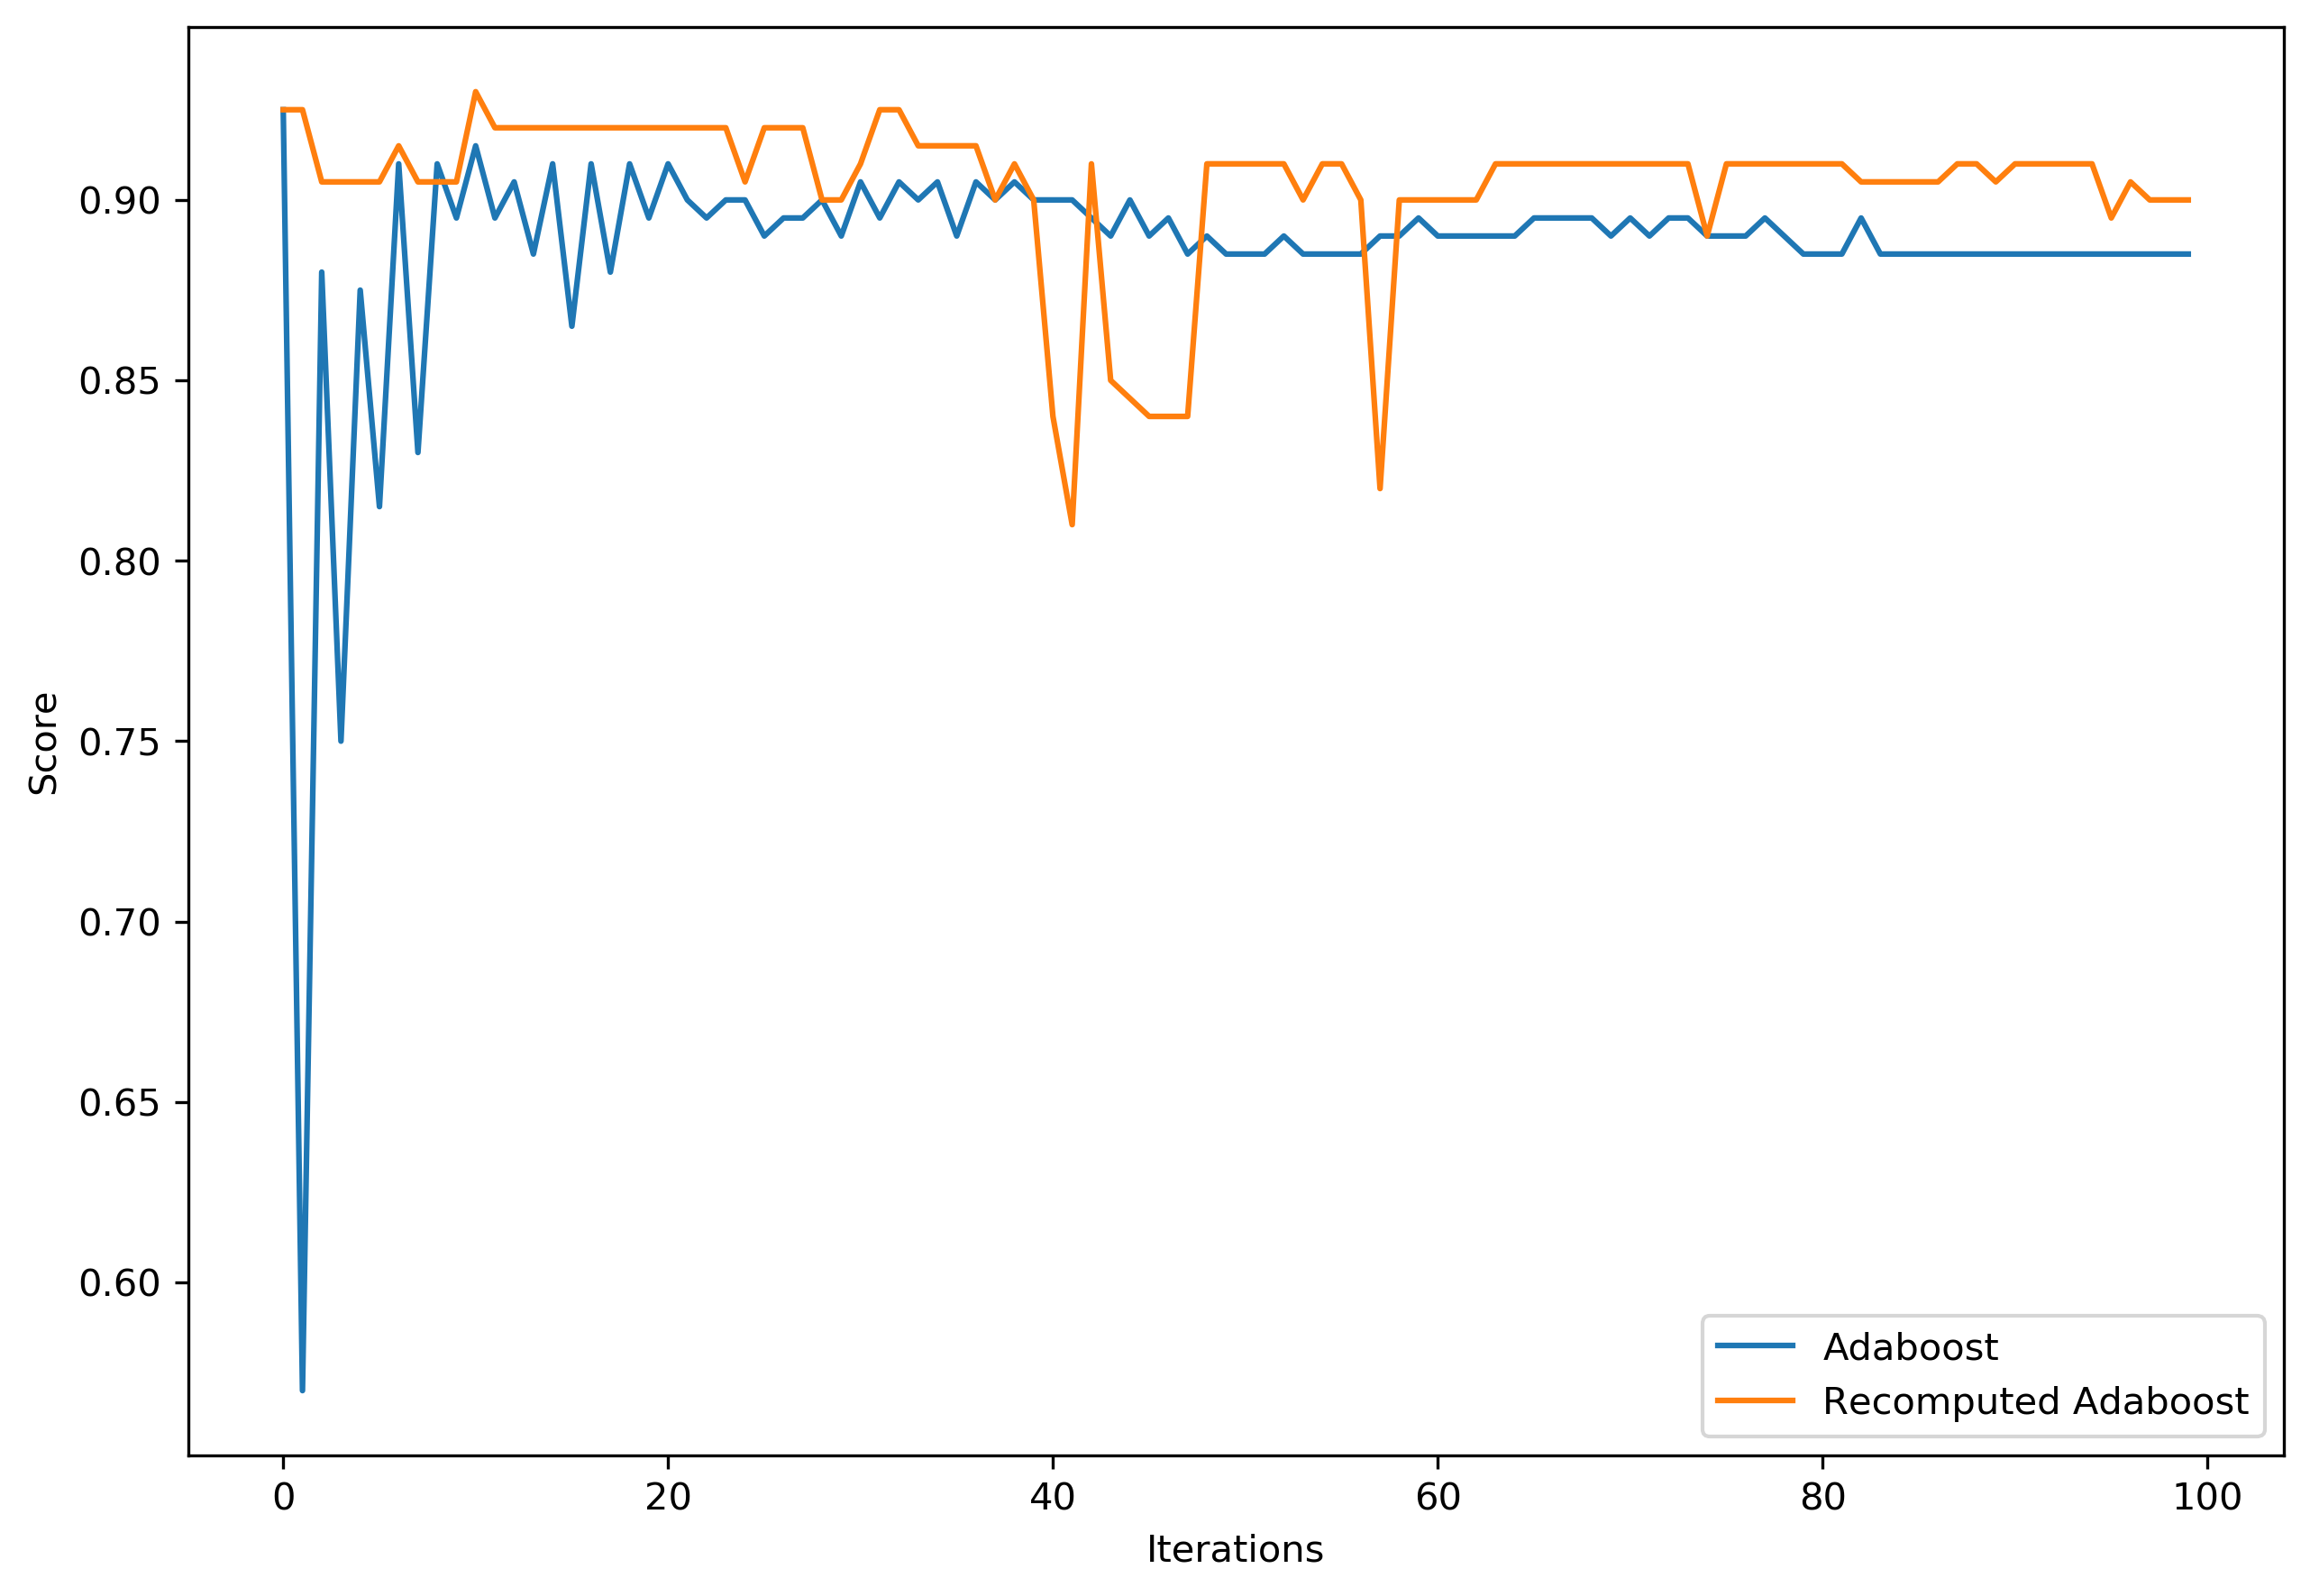

In [20]:
## Plot the scores of the models at each iteration (each iteration - each estimator added to the ensemble) 
# plt.plot(range(len(ada_boost.scoresit)),ada_boost.scoresit)
adb1alphas = np.flip(construct_alpha_history(ada_boost1.alphas))

ada1scores = []
for i in range(len(ada_boost1.classifiers)):
  ada1scores.append(score(adb1alphas[0:i+1,i], ada_boost1.classifiers[0:i+1], X_test, y_test))
  
adascores = []
for i in range(len(ada_boost.classifiers)):
  adascores.append(score(ada_boost.alphas[0:i+1,i], ada_boost.classifiers[0:i+1], X_test, y_test))
  

plt.figure(figsize=(10,7),dpi=300)
plt.plot(range(len(ada1scores)),ada1scores,label='Adaboost')  
plt.plot(range(len(adascores)),adascores, label='Recomputed Adaboost')
plt.xlabel("Iterations")
plt.ylabel('Score')
plt.legend()


## for AdaBoost and RecomputedAdaBoost

Make a conclusion about which method is better and in which case. 

Your answer:

As I have experimented a bit with the depthы of trees and thus I have concluded that the second method works better when the depth of the tree is shallow. In the fisrt adaboost, its stumps can learn the complexity of the data on their own because the depths allows that, thus they perform better, but if you decsrease the depth you will see that first adaboost  no more performs as good as it did before. If you do the same thing with the seocond ada boost results will not change much.

## Task 2. Gradient Boosting and Feature Selection (1 point)

Gradient Boosting Machines (GBM) are a historical and logical continuation of the first boosting algorithms. In a way, one can consider AdaBoost as another variant of GBMs. These methods are the extremely powerful tools, widely used in industry, research and various machine learning competitions. 

In this task we offer to focus on one varinat of GBM called [XGBoost](https://github.com/dmlc/xgboost/tree/master/python-package). The dataset that is going to be used is  [Telecom Churn Dataset] (https://www.kaggle.com/becksddf/churn-in-telecoms-dataset). You will need to construct an XGBoost classification model, train it, plot the ROC curve, measure the training time and compare it to Random Forest. Afterwards, compare the models' feature importances. 

**The task**
* train the XGBoost classifier on the provided dataset
* measure the training time
* measure the precision/recall on the test set
* plot ROC-curve
* train Random Forest classifier and compare it to XGBoost (plot ROC-curve)
* extract and compare the feature importances calculated by the previously trained XGBoost and Random Forest Classifiers. Are they different or the same, why?
* Fit the models to the iteratively reduced subset of features -in order to fo that, firstly, sort the feature importances in the decreasing order; then fit the models on the iteratively reduced feature subsets corresponding to the currently chosen threshold of the feature importance and plot the precision-recall. **HINT**: you can use ```sklearn.feature_selection.SelectFromModel``` and  its ```.transform``` methods in order to get the new $X$,$y$ subsets (according to the current threshold of the feature importance).

Make sure that you have installed the XGBoost package before starting the task. 

**HINT**: in order to measure the training time you can use [**timeit** cell magic](http://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit). 

In [21]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import pandas as pd
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('data/telecom_churn.csv')
cols = ['account length','number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn']
data = data[cols]
data.iloc[:,-1] = pd.Categorical(data.iloc[:,-1])
data.iloc[:,-1] = data.iloc[:,-1].cat.codes
X, y = data.iloc[:,:-1], data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                    random_state=0x0BADBEEF)

* train the XGBoost classifier on the provided dataset
* measure the training time
* measure the precision/recall on the test set
* plot ROC-curve
* train Random Forest classifier and compare it to XGBoost (plot ROC-curve)

In [22]:
###YOUR CODE###
%timeit clf1 = XGBClassifier(n_jobs=-1).fit(X_train,y_train)
%timeit clf2 = RandomForestClassifier(n_jobs=-1).fit(X_train,y_train)
print("GXBoost is faster almost 2 times!")

127 ms ± 2.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
242 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GXBoost is faster almost 2 times!


Average precision of XGBoost 0.751, precison 0.88, recall 0.547
Average precision of RandomForest 0.74, precison 0.917, recall 0.493


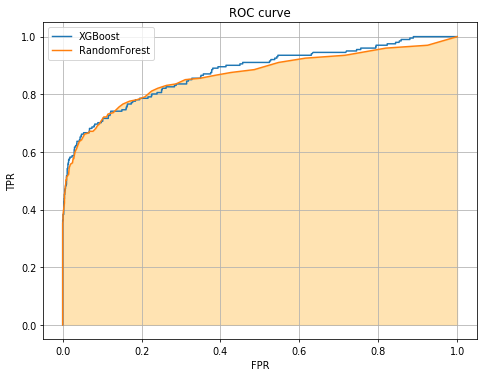

In [23]:
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import recall_score, precision_score

clf1 = XGBClassifier(n_jobs=-1).fit(X_train,y_train)
clf2 = RandomForestClassifier(n_jobs=-1).fit(X_train,y_train)

clf1probil = clf1.predict_proba(X_test)[:,1]
clf2probil = clf2.predict_proba(X_test)[:,1]

clf1precision, clf1recall = precision_score(y_test, clf1.predict(X_test)), recall_score(y_test,clf1.predict(X_test))
clf2precision, clf2recall = precision_score(y_test,clf2.predict(X_test)),recall_score(y_test,clf2.predict(X_test))

clf1_avpre = average_precision_score(y_test, clf1probil)
clf2_avpre = average_precision_score(y_test, clf2probil)

fal_pos_rate_clf1, tr_pos_rate_clf1, thresh_clf1 = roc_curve(y_test, clf1probil)
fal_pos_rate_clf2, tr_pos_rate_clf2, thresh_clf2 = roc_curve(y_test, clf2probil)

plt.figure(figsize=(8,6),dpi=70)
plt.title("ROC curve")
plt.plot(fal_pos_rate_clf1, tr_pos_rate_clf1,label='XGBoost')
plt.plot(fal_pos_rate_clf2, tr_pos_rate_clf2,label='RandomForest')
plt.fill_between(fal_pos_rate_clf2, tr_pos_rate_clf2, alpha=0.3,color='orange')
plt.xlabel("FPR")

plt.ylabel("TPR")
plt.legend()
plt.grid()

print("Average precision of XGBoost {:.3}, precison {:.3}, recall {:.3}".format(clf1_avpre, clf1precision, clf1recall))
print("Average precision of RandomForest {:.3}, precison {:.3}, recall {:.3}".format(clf2_avpre, clf2precision, clf2recall))


* extract and compare the feature importances calculated by the previously trained XGBoost and Random Forest Classifiers. Are they different or the same, why?

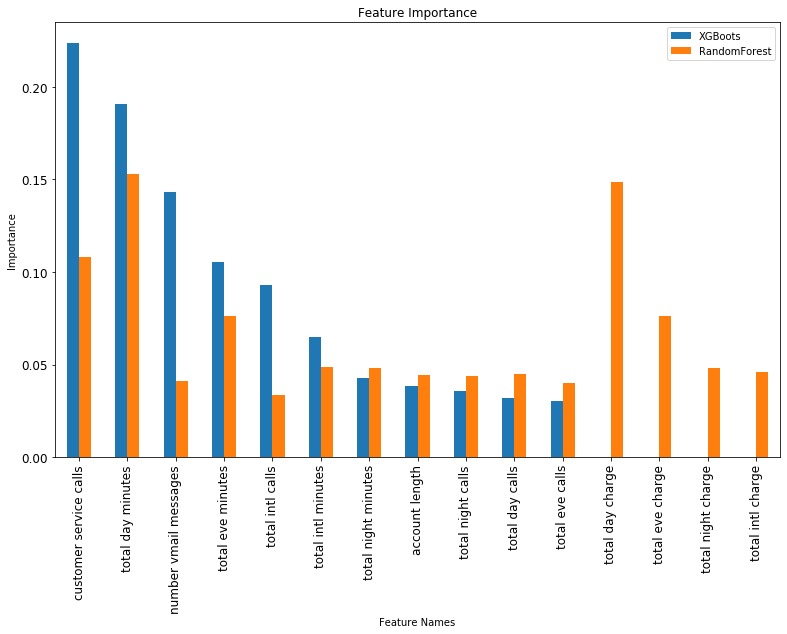

In [24]:
###YOUR CODE###
df = pd.DataFrame(data=np.array([clf1.feature_importances_ , clf2.feature_importances_]).T,
index=data.columns[:-1]).sort_values(by=[0],ascending=False)
df.columns=["XGBoots","RandomForest"]

ax=df.plot.bar(figsize=(13, 8), legend=True, fontsize=12,title ="Feature Importance")
ax.set_xlabel('Feature Names')
ax.set_ylabel('Importance')
plt.show()


**As we can see the feature importances for the classifiers are not the same. RF assigns at least some values to all it's features whereas XGBoost see some featurea as not imortant at all. This must have to do with how the XGBoost is constracuted. I don not know exactly the internal's of the XGboost classifier but must be similar to Gradient Boosting where each tree is build on the missmatched of the previsous and thus some features are not important at all. Also, I assume that the features that do not have good Gini are not important. RF on the other hand uses boostrapping with random sampeling of reatures thus every featues has at least some weight**

* Fit the models to the iteratively reduced subset of features -in order to fo that, firstly, sort the feature importances in the decreasing order; then fit the models on the iteratively reduced feature subsets corresponding to the currently chosen threshold of the feature importance and plot the precision-recall. **HINT**: you can use ```sklearn.feature_selection.SelectFromModel``` and  its ```.transform``` methods in order to get the new $X$,$y$ subsets (according to the current threshold of the feature importance).

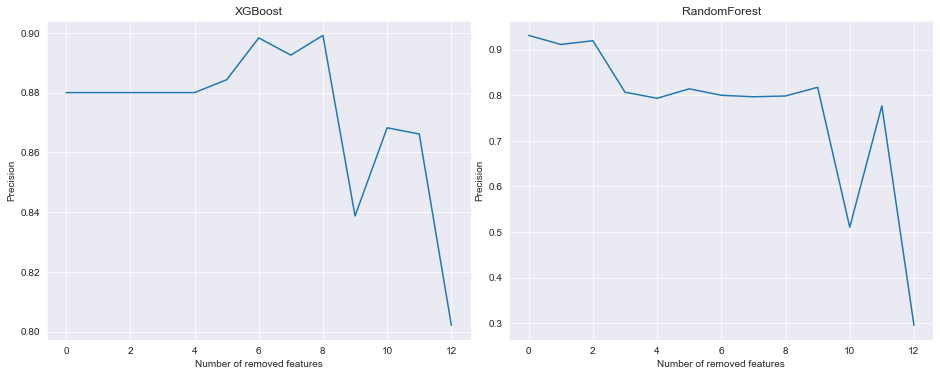

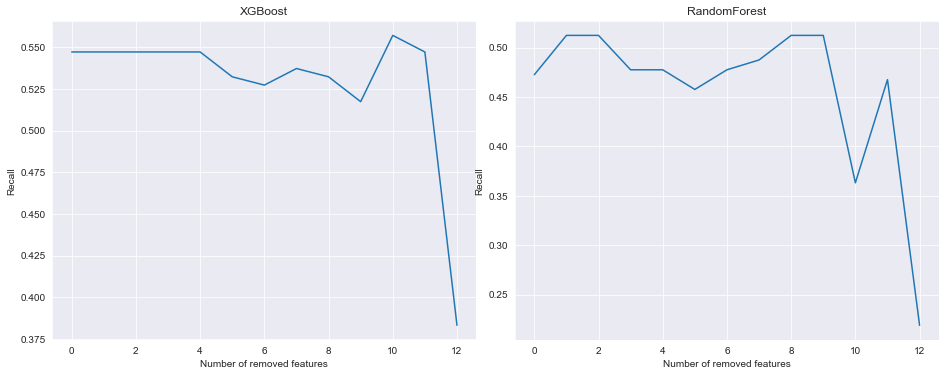

In [25]:
###YOUR CODE###
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import recall_score, precision_score
from sklearn.base import clone
import seaborn as sns 
sns.set_style('darkgrid')

clf11 = clone(clf1)
clf22 = clone(clf2)

imp1 = clf1.feature_importances_
imp2 = clf2.feature_importances_
sort1 = np.argsort(imp1)
sort2 = np.argsort(imp2)
precision1, precision2 = [],[]
recall1, recall2 = [],[]

for i,j in zip(sort1,sort2):
  sel1 = SelectFromModel(estimator=clf11, threshold=imp1[i]).fit(X_train,y_train)
  sel2 = SelectFromModel(estimator=clf22, threshold=imp2[j]).fit(X_train,y_train)
  
  X_train_new1 = sel1.transform(X_train.copy())
  X_test_new1 = sel1.transform(X_test.copy())
  X_train_new2 = sel2.transform(X_train.copy())
  X_test_new2 = sel2.transform(X_test.copy())
  
  if X_test_new2.shape[1] <= 1 or X_test_new1.shape[1] <= 1:
    break
  clf11.fit(X_train_new1,y_train)
  precision1.append(precision_score(y_test,clf11.predict(X_test_new1)))
  recall1.append(recall_score(y_test,clf11.predict(X_test_new1)))
  
  clf22.fit(X_train_new2,y_train)
  precision2.append(precision_score(y_test,clf22.predict(X_test_new2)))
  recall2.append(recall_score(y_test,clf22.predict(X_test_new2)))
  

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout()
ax1.plot(range(len(precision1)),precision1)
ax1.set_title('XGBoost')
ax1.set_xlabel('Number of removed features')
ax1.set_ylabel('Precision');

ax2.plot(range(len(precision2)),precision2)
ax2.set_title('RandomForest');
ax2.set_xlabel('Number of removed features')
ax2.set_ylabel('Precision');
 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,5))
plt.tight_layout()
ax1.plot(range(len(recall1)),recall1)
ax1.set_title('XGBoost')
ax1.set_xlabel('Number of removed features')
ax1.set_ylabel('Recall');

ax2.plot(range(len(recall2)),recall2)
ax2.set_title('RandomForest');
ax2.set_xlabel('Number of removed features')
ax2.set_ylabel('Recall');


# Task 3. Bayesian methods (1 point)

In this task you are asked to compare the performance of the common Ridge Regression with its the parameters chosen using cross-validation technique and Bayesian Ridge Regression. 

In particular, using [Cross-Validation](https://scikit-learn.org/stable/modules/cross_validation.html), find the optimal value for the reguralization coefficient in the ridge regression optimization problem formulation. Then train [Bayesian Regression](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression) and compare the absolute error and learnt coefficients distribution for both variants and make some conclusions on both methods.

**The task:** 
* Use crossvalidation technique to choose the optimal value of reguralization coefficent for Ridge Regression model. (**Note:** "optimal" value here, means the one that lets the model with this particular parameter value achieve better performance compared to the other variants). 
* Fit Bayesian Ridge Regression model 
* Plot the absolute error historgramms for both models using [seaborn.distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html).
* Plot historgrams of coefficients of regression derived from both models (in cross-validation case the coefficients of the best model)
* Compare the two pairs of histrograms. Are they the same or different? Why? What are the prons and cons of both methods?

In [26]:
import sklearn.datasets as dt
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, BayesianRidge
import seaborn as sns

In [27]:
X,y = dt.load_boston(return_X_y=True)
X_train = X[:400]
y_train = y[:400]
X_test = X[400:]
y_test = y[400:]

In [28]:
###YOUR CODE###
params = {'alpha': np.linspace(1,1000,100)}
clfRg = GridSearchCV(Ridge(normalize=True),param_grid=params, cv=5,n_jobs=-1,).fit(X_train,y_train)
clfBR = BayesianRidge().fit(X_train,y_train)

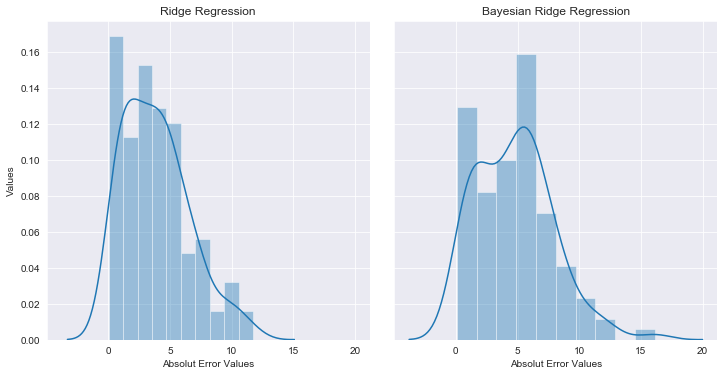

In [29]:
errrg = abs(y_test - clfRg.predict(X_test))
errbr = abs(y_test - clfBR.predict(X_test))

fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5),)
plt.tight_layout()
sns.distplot(errrg, bins=10,ax=ax1)
ax1.set_title('Ridge Regression')
ax1.set_xlabel('Absolut Error Values')
sns.distplot(errbr, bins=10,ax=ax2)
ax2.set_title('Bayesian Ridge Regression');
ax2.set_xlabel('Absolut Error Values')
ax1.set_ylabel('Values');

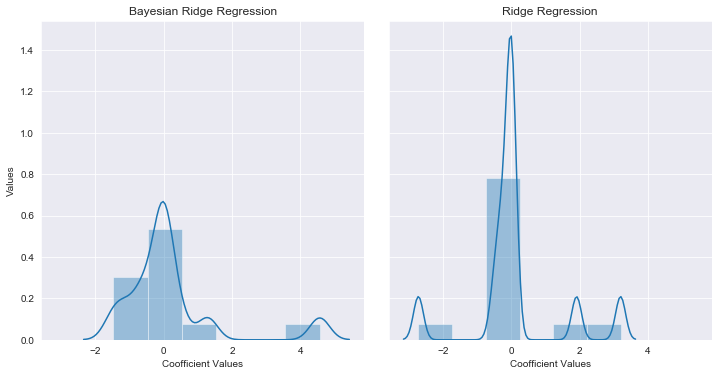

In [30]:
fig, (ax1,ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))
plt.tight_layout()
sns.distplot(clfBR.coef_,bins=6,ax=ax1);
ax1.set_title('Bayesian Ridge Regression')
ax1.set_xlabel('Coofficient Values')
sns.distplot(clfRg.best_estimator_.coef_,bins=6,ax=ax2);
ax2.set_title('Ridge Regression');
ax2.set_xlabel('Coofficient Values')
ax1.set_ylabel('Values');

**Discussion**

* We can see that the error histograms look similar but if we have a closer look, we can see that the absolute values of Bayesian Ridge Regression are more dispersed, which means the model has made more errors compare to  Ridge Regression. Ridge Regression uses L2 reguralization where as Bayesian Ridge Regression is defined in probabilistic terms with explicit priors  on the parameters. The choise of parametes can have regularization effect. The models are not the same because ridge regreesion is a kind of regression model and bayesian approach is a way defining and estimating statistical model.

* Bayesin Ridge Regression prodived predction and variance( certainty) of the prediction. Faster to fit the model when greed search is needed to find the best parameters. Can make vary vage predictions even when data is insaficienct.

* Ridge Regression is more robust, faster to fit. Easy to understand.
   

   

# Task 4. Stacking (2 point)

Stacking is another approach to combine several algorithms to get better results.Basically stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The main concept is to learn base models on some set of features then train meta model, which uses the predictions of base models as features. This technique is wiledly used in multiple real case scenarios to get better results. One of the main problem of stacking is, of course, overfitting. To avoid it, the training set is divided into $ n $ folds, $ (n-1) $ of which are used for training the base models, and $ n $ -th for the overall prediction (calculating the meta-factor). In order to train the meta-model, it should receive predictions from the base models for those objects of the training sample on which the meta-model will be trained. 

There are various of stacking approaches$.^{[1]}$ For example, in order, to obtain meta-factors for test data, the base classifiers can be trained on the entire training set, since the problem of overfitting does not arise here. In other words, if we want to calculate the factors for the test set, we can safely use the training set to train the base classifiers. If we want to calculate factors for the training set, then it is necessary to ensure that the classifier does not predict for those objects on which it has been trained$.^{[2]}$ You can read more details about stacking [blockpost](https://blog.statsbot.co/ensemble-learning-d1dcd548e936), [kaggle ensemble guide](https://mlwave.com/kaggle-ensembling-guide/).

P.s. Stacking and Blending are two similar approaches to combining classifiers (ensembling). The difference is that Stacking uses out-of-fold predictions for the train set, and Blending uses a validation set to train the next layer [source](quora.com/What-are-examples-of-blending-and-stacking-in-Machine-Learning). Because they are so similar you can use any of them. 

[1] http://www.machinelearning.ru/wiki/images/5/56/Guschin2015Stacking.pdf  
[2] MLgroup SHAD

**The task:**

* Complete the ```meta_classfier``` function
* Choose 6 different base models(base models can be any models that you know, and can differ between each other by different hyperparameters, models of ml,features e.t.c) and train them.
* Report individual scores on test set for each of the models. As a score use accuracy.
* Train metaclassifier on original datasets features, report score on test.
* Train meta_classifier on those base models. Report the test score (accuracy) in this case.
* Does stacking helped to gain better score?

Enough of theory, let's get back to Practice. Download dataset fetch_covertype from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_covtype.html#sklearn.datasets.fetch_covtype) and  split it train-test - 60/40.
More detail about this dataset you can find [here](https://archive.ics.uci.edu/ml/datasets/Covertype)

In [31]:
import sklearn
fc = sklearn.datasets.fetch_covtype()

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fc['data'], fc['target'], test_size=0.4)

Write meta classifier function.

In [33]:
from sklearn.model_selection import StratifiedKFold,KFold

def meta_classifier(base_clfs, final_calssifier, X_train, X_test, y_train, cv):
    """
    Meta classifier prediction using stacking. 
    Input:
    :param base_clfs: list,  base classifiers which will be stacked together.
    :param final_classifier: estimator, a classifier which will be used to combine the base estimators. 
    :param X_train: numpy array or pandas table, train set.
    :param X_test: numpy array or pandas table, target for train set.
    :param X_train: numpy array or pandas table, test set.
    
    Output:
    :param y_pred: numpy array or pandas table, prediction of meta classifier using stacking on test set.
    :param final_classifier(optional): estimator, trained final_calssifier.
    
    
    More details https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html
    
    """
    ###YOUR CODE###
    clfspreds = np.zeros((y_train.shape[0], len(base_clfs)))
    for z,clf in enumerate(base_clfs):
      predictions = []
      skf = KFold(n_splits=cv)
      skf.get_n_splits(X_train, y_train)
      KFold(n_splits=cv, random_state=None, shuffle=False)
      for train_index, test_index in skf.split(X_train, y_train):
          X_train_, X_test_ = X_train[train_index], X_train[test_index]
          y_train_, y_test_ = y_train[train_index], y_train[test_index]
          clf.fit(X_train_,y_train_)
          y_pred = clf.predict(X_test_)
          predictions.append(y_pred)
      clfspreds[:,z]=np.concatenate(predictions,axis=0)

    ## Fit meta classifier 
#     X_train_new = np.concatenate((X_train,clfspreds),axis=1)
    final_calssifier.fit(clfspreds,y_train)
    
    ## Predict using meta classifier
    meta = np.zeros((X_test.shape[0],len(base_clfs)))
    for i,clf in enumerate(base_clfs):
      y_pred = clf.predict(X_test)
      meta[:,i] = y_pred
#     X_test_new = np.concatenate((X_test,meta),axis=1)
    finala_prediction = final_calssifier.predict(meta)
    
    return finala_prediction,base_clfs


Chose 6 different base models(base models can be any models that you know,and can differ with each other by different hyperparameters,  models of ml,features e.t.c) and train them. 

In [34]:
###YOUR CODE###
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler


clf1 = RandomForestClassifier(n_jobs=-1,verbose=True).fit(X_train,y_train)
clf2 = KNeighborsClassifier(n_neighbors=7,n_jobs=-1).fit(X_train,y_train)
print(1)
clf3 = DecisionTreeClassifier(max_depth=10).fit(X_train,y_train)
print(2)
clf4 = QuadraticDiscriminantAnalysis().fit(X_train,y_train)
print(3)
clf5 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2)).fit(X_train,y_train)
print(4)
clf6 = GaussianNB().fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.9s finished


1
2
3
4


Report individual scores on test set. As a score use accuracy.

In [35]:
###YOUR CODE###
from sklearn.metrics import accuracy_score
print('Accuracies:')
print("RandomForest: {:.4}".format(accuracy_score(y_test,clf1.predict(X_test))))
print("KNeighbors: {:.4}".format(accuracy_score(y_test,clf2.predict(X_test))))
print("DecisionTree: {:.4}".format(accuracy_score(y_test,clf3.predict(X_test))))
print("QuadraticDiscriminantAnalysis: {:.4}".format(accuracy_score(y_test,clf4.predict(X_test))))
print("AdaBoostClassifier: {:.4}".format(accuracy_score(y_test,clf5.predict(X_test))))
print("GaussianNB: {:.4}".format(accuracy_score(y_test,clf6.predict(X_test))))      

Accuracies:


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.1s finished


RandomForest: 0.9501
KNeighbors: 0.9599
DecisionTree: 0.778
QuadraticDiscriminantAnalysis: 0.0823
AdaBoostClassifier: 0.5274
GaussianNB: 0.4566


Train metaclassifier on original datasets features. And report score on test.

In [36]:
###YOUR CODE###
from sklearn.linear_model import LogisticRegression

clfL = LogisticRegression(multi_class='ovr',n_jobs=-1).fit(X_train,y_train)
print('Accuracy:')
print("Meta classifer's (LogisticRegression) {:.4}".format(accuracy_score(y_test,clfL.predict(X_test))))

Accuracy:
Meta classifer's (LogisticRegression) 0.6457


Train meta_classifier on those base models .

In [37]:
###YOUR CODE###

base_clfs = [RandomForestClassifier(),
             KNeighborsClassifier(n_neighbors=7),
             DecisionTreeClassifier(max_depth=10),
             QuadraticDiscriminantAnalysis(),
             AdaBoostClassifier(DecisionTreeClassifier(max_depth=2)),
             GaussianNB()]

clfm = meta_classifier(base_clfs, LogisticRegression(), X_train, X_test, y_train, cv=3)


Report score(accuracy) on test. 

In [38]:
###YOUR CODE###
print('Accuracy:')
print("Meta Classifier trained on base models: {:.4}".format(accuracy_score(y_test,clfm[0])))

Accuracy:
Meta Classifier trained on base models: 0.9209


Does stacking helped to gain better score?

Your answer

As you can see the stacking has given better estimates than the matalearner alone(for the same classifier is a metalearner), in that sense it's obvisouly better. But if we compare it with one of the best base classifiers than we can see that stacking slitly under preforms. May be this has to do with initial parameters of the base classifiers. 

# Task 5. Gaussian Processes (1 point)

In the following exercise you will need to fit the gaussian process with different kernels on the ```elecricity_conpumption_FR.csv``` time series data. We have already loaded and prepared the train/test datasets for you below.

Use [**GPy**](https://pypi.python.org/pypi/GPy) library for training and prediction. Fit a GP and run the predict on the test. Useful kernels to combine: `GPy.kern.RBF, GPy.kern.Poly, GPy.kern.StdPeriodic, GPy.kern.White, GPy.kern.Linear`. 

**The task**:
* Normalize the target value by fitting a transformation on the train (use ```sklearn.preprocessing.StandardScaler```)
* Plot the resulting target against the time index.
* Plot mean and confidence interval of the prediction. 
* Inspect them on normality by scatter plot: plot predicted points/time series against true values. 
* Estimate the prediction error with `r2_score`. R2-score accepted > 0.7 on test sample.

In [39]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

In [40]:
data = pd.read_csv('data/elecricity_conpumption_FR.csv')


In [41]:
data.dropna(inplace=True)

In [42]:
y = np.array(data.values)
X = np.array(data.index)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

* Normalize the target value by fitting a transformation on the train (use ```sklearn.preprocessing.StandardScaler```)
* Plot the resulting target against the time index.

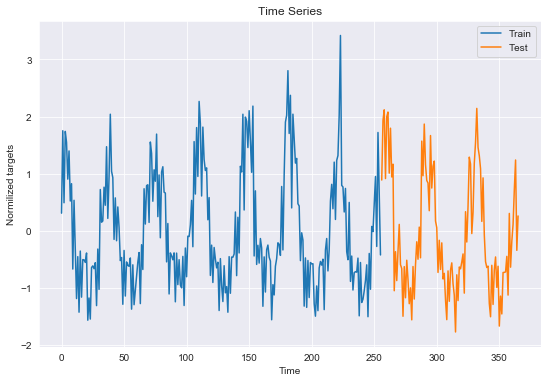

In [44]:
###YOUR CODE###
import seaborn as sns 
sns.set_style("darkgrid")

scalar = StandardScaler().fit(y_train.reshape(-1,1))
y_train_new = scalar.transform(y_train)
y_test_new = scalar.transform(y_test)

plt.figure(figsize=(9,6))
plt.title("Time Series")
plt.plot(X_train,y_train_new,label="Train")
plt.plot(X_test,y_test_new,label="Test")
plt.xlabel('Time')
plt.ylabel('Normilized targets');
plt.legend()

In [45]:
from GPy.models import GPRegression
from GPy.kern import RBF, Poly, StdPeriodic, White, Linear,PeriodicExponential
from sklearn.metrics import r2_score
import GPy.kern as kern

* Plot mean and confidence interval of the prediction. 
* Inspect them on normality by scatter plot: plot predicted points/time series against true values. 
* Estimate the prediction error with `r2_score`. R2-score accepted > 0.7 on test sample.

Optimization restart 1/20, f = 218.3448108432285
Optimization restart 2/20, f = 218.50509234415392
Optimization restart 3/20, f = 361.57802211483727
Optimization restart 4/20, f = 234.30009447593415
Optimization restart 5/20, f = 357.19960062254586
Optimization restart 6/20, f = 309.9259711058862
Optimization restart 7/20, f = 363.24826547990295
Optimization restart 8/20, f = 365.3490618479281
Optimization restart 9/20, f = 363.2482674196543
Optimization restart 10/20, f = 367.84333140072556
Optimization restart 11/20, f = 234.173120978285
Optimization restart 12/20, f = 363.2482651964693
Optimization restart 13/20, f = 234.64624971368386
Optimization restart 14/20, f = 355.9967792348069
Optimization restart 15/20, f = 367.35946025484236
Optimization restart 16/20, f = 989.4465578124078
Optimization restart 17/20, f = 362.7757496420469
Optimization restart 18/20, f = 355.4814268572758
Optimization restart 19/20, f = 218.40163954237585
Optimization restart 20/20, f = 237.9048560144233


GP_regression.,value,constraints,priors
std_periodic.variance,1.2290773108555326,+ve,
std_periodic.period,36.50254623114493,+ve,
std_periodic.lengthscale,0.7255736248605336,+ve,
Gaussian_noise.variance,0.29260234443837374,+ve,


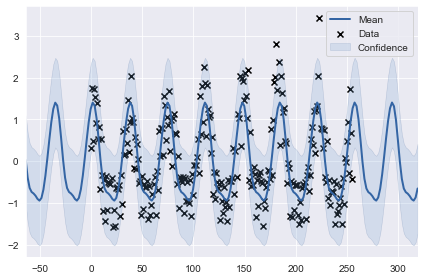

In [46]:
#### YOUR CODE###
import GPy
kernal =  StdPeriodic(1,variance=0.4, period=40)
m = GPRegression(X_train,y_train_new,kernal)
m.optimize(optimizer='tnc')
m.optimize_restarts(num_restarts = 20)
display(m)
m.plot();


r2 score:  0.7216464378428801


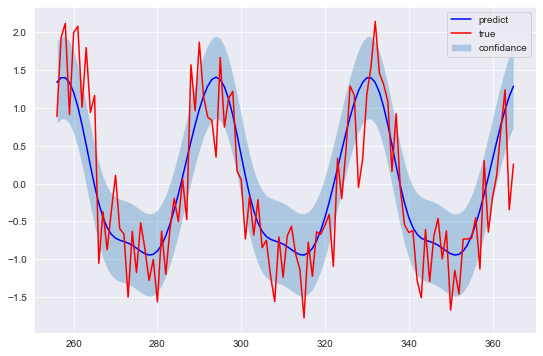

In [47]:
print('r2 score: ', r2_score(y_test_new,m.predict(X_test)[0]))
prediction_mean, prediction_var = m.predict(X_test)
prediction_std = np.sqrt(prediction_var).ravel()
prediction_mean = prediction_mean.ravel()


plt.figure(figsize=(9,6))
plt.plot(X_test,m.predict(X_test)[0],c='blue',label='predict')
plt.plot(X_test,y_test_new,label='true',c='r')
plt.fill_between(X_test.ravel(), prediction_mean - prediction_std, prediction_mean + prediction_std, alpha=0.3,
                 label='confidance')
plt.legend();


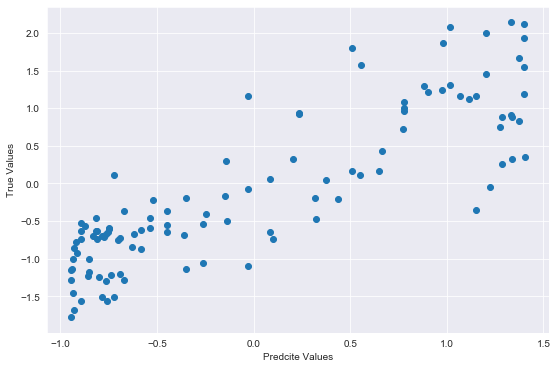

In [48]:
plt.figure(figsize=(9,6))
plt.scatter((m.predict(X_test)[0]),y_test_new)
plt.ylabel("True Values");
plt.xlabel('Predcite Values');
